# SMS Spam Classifier using NLP

This notebook demonstrates how to build a machine learning model to classify SMS messages as 'spam' or 'ham' (legitimate messages) using Natural Language Processing techniques.

## Project Overview

- **Objective**: Build an SMS spam detection system
- **Dataset**: SMS Spam Collection Dataset
- **Algorithm**: Multinomial Naive Bayes
- **Features**: TF-IDF (Term Frequency-Inverse Document Frequency) vectors
- **Text Processing**: Cleaning, stemming, stopword removal

## Table of Contents
1. [Import Libraries](#1-import-libraries)
2. [Load Dataset](#2-load-dataset)
3. [Data Exploration](#3-data-exploration)
4. [Data Preprocessing](#4-data-preprocessing)
5. [Feature Extraction](#5-feature-extraction)
6. [Model Training](#6-model-training)
7. [Model Evaluation](#7-model-evaluation)
8. [Interactive Prediction](#8-interactive-prediction)

## 1. Import Libraries

First, let's import all the necessary libraries for our SMS spam classification project.

In [1]:
# Data manipulation and analysis
import pandas as pd

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Natural Language Processing
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Text processing
import string

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Download NLTK data (run once)
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Aditya\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Aditya\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

## 2. Load Dataset

The dataset should be named `spam.csv` and placed in the same directory as this notebook. The dataset contains two main columns:
- `v1`: Label (ham/spam)
- `v2`: SMS message text

**Dataset Source**: You can download the SMS Spam Collection Dataset from [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/sms+spam+collection)

In [2]:
# Load the dataset
try:
    df = pd.read_csv('spam.csv', encoding='latin-1')
    df = df.iloc[:, :2]  # Select the first two columns
    df.columns = ['label', 'message']
    print("Dataset loaded successfully. First 5 rows:")
    print(df.head())
    print("\nDataset shape:", df.shape)
except FileNotFoundError:
    print("Error: 'spam.csv' not found. Please ensure the file is in the same directory.")
    print("You can download it from: https://archive.ics.uci.edu/ml/datasets/sms+spam+collection")

Dataset loaded successfully. First 5 rows:
  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...

Dataset shape: (5572, 2)


## 3. Data Exploration

Let's explore our dataset to understand the distribution of spam vs ham messages and get insights into our data.

In [3]:
print("--- Data Exploration ---")
print("Class distribution:")
print(df['label'].value_counts())

# Calculate percentages
percentages = df['label'].value_counts(normalize=True) * 100
print("\nClass distribution (percentages):")
print(percentages)

--- Data Exploration ---
Class distribution:
label
ham     4825
spam     747
Name: count, dtype: int64

Class distribution (percentages):
label
ham     86.593683
spam    13.406317
Name: proportion, dtype: float64


C:\Users\Aditya\AppData\Local\Temp\ipykernel_35724\3490748149.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='viridis')


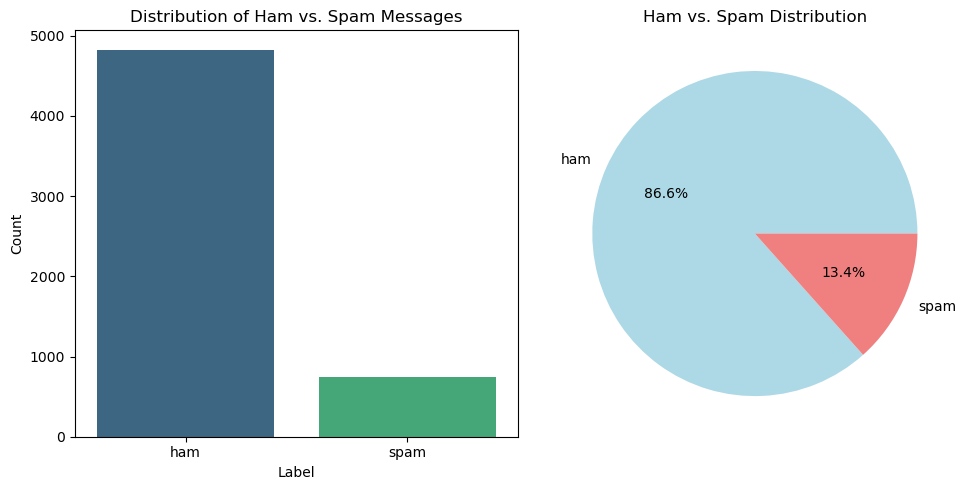

In [4]:
# Visualize the class distribution
plt.figure(figsize=(10, 5))

# Count plot
plt.subplot(1, 2, 1)
sns.countplot(x='label', data=df, palette='viridis')
plt.title('Distribution of Ham vs. Spam Messages')
plt.xlabel('Label')
plt.ylabel('Count')

# Pie chart
plt.subplot(1, 2, 2)
df['label'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['lightblue', 'lightcoral'])
plt.title('Ham vs. Spam Distribution')
plt.ylabel('')  # Remove default ylabel

plt.tight_layout()
plt.show()

Message length statistics:
        count        mean        std   min    25%    50%    75%    max
label                                                                 
ham    4825.0   71.023627  58.016023   2.0   33.0   52.0   92.0  910.0
spam    747.0  138.866131  29.183082  13.0  132.5  149.0  157.0  224.0


C:\Users\Aditya\AppData\Local\Temp\ipykernel_35724\3105883756.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='message_length', data=df, palette='Set2')


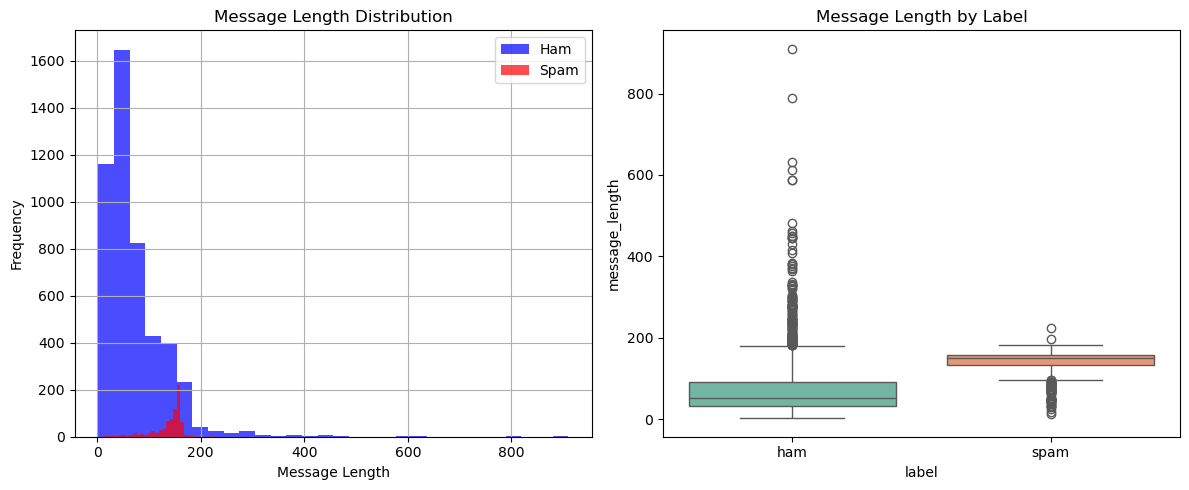

In [5]:
# Explore message lengths
df['message_length'] = df['message'].str.len()

print("Message length statistics:")
print(df.groupby('label')['message_length'].describe())

# Plot message length distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
df[df['label'] == 'ham']['message_length'].hist(bins=30, alpha=0.7, label='Ham', color='blue')
df[df['label'] == 'spam']['message_length'].hist(bins=30, alpha=0.7, label='Spam', color='red')
plt.xlabel('Message Length')
plt.ylabel('Frequency')
plt.title('Message Length Distribution')
plt.legend()

plt.subplot(1, 2, 2)
sns.boxplot(x='label', y='message_length', data=df, palette='Set2')
plt.title('Message Length by Label')

plt.tight_layout()
plt.show()

## 4. Data Preprocessing

Text preprocessing is crucial for NLP tasks. We'll perform the following steps:
1. Convert labels to numerical format
2. Clean text data (lowercase, remove punctuation, remove stopwords, stemming)

### 4.1 Label Encoding

In [6]:
# Convert labels to numerical format (0 for ham, 1 for spam)
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])
print("Labels encoded. First 5 rows with numerical labels:")
print(df[['label', 'message']].head())
print("\nLabel mapping:")
print("0 -> Ham (Legitimate)")
print("1 -> Spam")

Labels encoded. First 5 rows with numerical labels:
   label                                            message
0      0  Go until jurong point, crazy.. Available only ...
1      0                      Ok lar... Joking wif u oni...
2      1  Free entry in 2 a wkly comp to win FA Cup fina...
3      0  U dun say so early hor... U c already then say...
4      0  Nah I don't think he goes to usf, he lives aro...

Label mapping:
0 -> Ham (Legitimate)
1 -> Spam


### 4.2 Text Cleaning Function

We'll create a comprehensive text cleaning function that:
- Converts text to lowercase
- Removes punctuation
- Removes stopwords (common words like 'the', 'a', 'is')
- Applies stemming (reduces words to their root form)

In [7]:
def clean_text(text):
    """
    Comprehensive text cleaning function.
    
    Steps:
    1. Convert to lowercase
    2. Remove punctuation
    3. Remove stopwords
    4. Apply stemming
    
    Args:
        text (str): Input text to clean
    
    Returns:
        str: Cleaned text
    """
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation
    text = ''.join([char for char in text if char not in string.punctuation])
    
    # Remove stopwords
    stop_words = stopwords.words('english')
    text = ' '.join([word for word in text.split() if word not in stop_words])
    
    # Apply stemming
    stemmer = PorterStemmer()
    text = ' '.join([stemmer.stem(word) for word in text.split()])
    
    return text

# Test the function with a sample message
sample_text = "Hello! This is a sample message with punctuation, stopwords, and words that need stemming."
print("Original text:")
print(sample_text)
print("\nCleaned text:")
print(clean_text(sample_text))

Original text:
Hello! This is a sample message with punctuation, stopwords, and words that need stemming.

Cleaned text:
hello sampl messag punctuat stopword word need stem


In [8]:
# Apply the cleaning function to all messages
print("Cleaning text data...")
df['cleaned_message'] = df['message'].apply(clean_text)
print("Text cleaning complete. First 5 cleaned messages:")
print(df[['message', 'cleaned_message']].head())

Cleaning text data...
Text cleaning complete. First 5 cleaned messages:
                                             message  \
0  Go until jurong point, crazy.. Available only ...   
1                      Ok lar... Joking wif u oni...   
2  Free entry in 2 a wkly comp to win FA Cup fina...   
3  U dun say so early hor... U c already then say...   
4  Nah I don't think he goes to usf, he lives aro...   

                                     cleaned_message  
0  go jurong point crazi avail bugi n great world...  
1                              ok lar joke wif u oni  
2  free entri 2 wkli comp win fa cup final tkt 21...  
3                u dun say earli hor u c alreadi say  
4          nah dont think goe usf live around though  


In [9]:
# Compare original vs cleaned message lengths
df['cleaned_length'] = df['cleaned_message'].str.len()
print("Length comparison (original vs cleaned):")
print(f"Average original length: {df['message_length'].mean():.2f}")
print(f"Average cleaned length: {df['cleaned_length'].mean():.2f}")
print(f"Average reduction: {((df['message_length'].mean() - df['cleaned_length'].mean()) / df['message_length'].mean()) * 100:.2f}%")

Length comparison (original vs cleaned):
Average original length: 80.12
Average cleaned length: 50.16
Average reduction: 37.40%


## 5. Feature Extraction

We'll use **TF-IDF (Term Frequency-Inverse Document Frequency)** to convert our cleaned text into numerical features that machine learning algorithms can understand.

### What is TF-IDF?
- **Term Frequency (TF)**: How often a word appears in a document
- **Inverse Document Frequency (IDF)**: How rare or common a word is across all documents
- **TF-IDF**: Combines both to give higher weights to words that are frequent in a document but rare across the corpus

In [10]:
print("Converting text to TF-IDF vectors...")

# Initialize TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=5000)  # Limit to top 5000 features

# Transform cleaned messages to TF-IDF vectors
X = tfidf.fit_transform(df['cleaned_message'])
y = df['label']

print("TF-IDF vectorization complete.")
print(f"Shape of feature matrix: {X.shape}")
print(f"Number of samples: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")

Converting text to TF-IDF vectors...
TF-IDF vectorization complete.
Shape of feature matrix: (5572, 5000)
Number of samples: 5572
Number of features: 5000


In [11]:
# Show top features (words) learned by TF-IDF
feature_names = tfidf.get_feature_names_out()
print("Sample of TF-IDF features (words):")
print(feature_names[:20])  # Show first 20 features

Sample of TF-IDF features (words):
['008704050406' '01223585334' '020603' '0207' '02073162414' '020903' '021'
 '050703' '0578' '071104' '07123456789' '07734396839' '07742676969'
 '0776xxxxxxx' '07786200117' '07821230901' '07xxxxxxxxx' '0800'
 '08000407165' '08000776320']


## 6. Model Training

We'll use **Multinomial Naive Bayes** classifier, which is particularly effective for text classification tasks.

### Why Naive Bayes?
- Works well with text data
- Fast training and prediction
- Good performance on spam detection
- Handles high-dimensional sparse data (like TF-IDF vectors) well

In [12]:
print("Splitting data and training the Multinomial Naive Bayes model...")

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

# Initialize and train the Naive Bayes classifier
model = MultinomialNB()
model.fit(X_train, y_train)
print("Model training complete.")

Splitting data and training the Multinomial Naive Bayes model...
Training set size: 4457 samples
Testing set size: 1115 samples
Model training complete.


## 7. Model Evaluation

Let's evaluate our model's performance using various metrics:
- **Accuracy**: Overall correctness
- **Precision**: Of all predicted spam, how many were actually spam?
- **Recall**: Of all actual spam, how many did we correctly identify?
- **F1-Score**: Harmonic mean of precision and recall

In [13]:
print("--- Model Evaluation ---")

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision: {precision:.4f} ({precision*100:.2f}%)")
print(f"Recall:    {recall:.4f} ({recall*100:.2f}%)")
print(f"F1-Score:  {f1:.4f} ({f1*100:.2f}%)")

print("\n--- Metric Interpretations ---")
print(f"✓ Out of 100 messages, {accuracy*100:.0f} are classified correctly")
print(f"✓ Out of 100 predicted spam messages, {precision*100:.0f} are actually spam")
print(f"✓ Out of 100 actual spam messages, {recall*100:.0f} are correctly identified")

--- Model Evaluation ---
Accuracy:  0.9677 (96.77%)
Precision: 0.9913 (99.13%)
Recall:    0.7651 (76.51%)
F1-Score:  0.8636 (86.36%)

--- Metric Interpretations ---
✓ Out of 100 messages, 97 are classified correctly
✓ Out of 100 predicted spam messages, 99 are actually spam
✓ Out of 100 actual spam messages, 77 are correctly identified


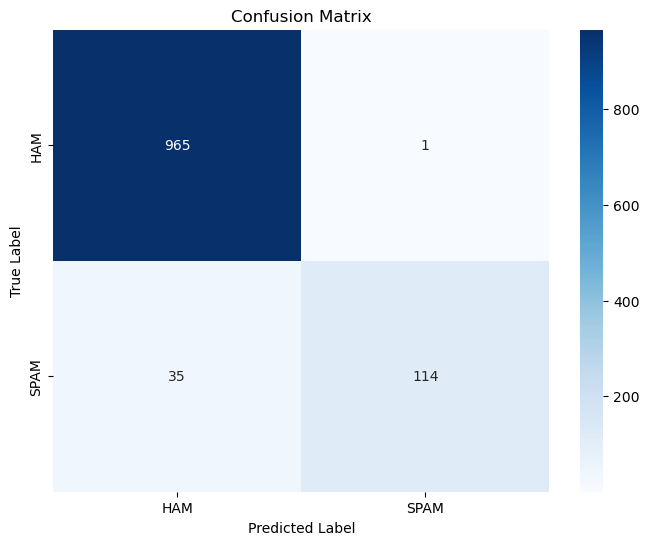


--- Confusion Matrix Breakdown ---
True Negatives (Ham → Ham): 965
False Positives (Ham → Spam): 1
False Negatives (Spam → Ham): 35
True Positives (Spam → Spam): 114


In [14]:
# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['HAM', 'SPAM'], yticklabels=['HAM', 'SPAM'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Interpret confusion matrix
tn, fp, fn, tp = cm.ravel()
print("\n--- Confusion Matrix Breakdown ---")
print(f"True Negatives (Ham → Ham): {tn}")
print(f"False Positives (Ham → Spam): {fp}")
print(f"False Negatives (Spam → Ham): {fn}")
print(f"True Positives (Spam → Spam): {tp}")

In [15]:
# Feature Importance Analysis
# Get the most important features for spam classification
feature_log_prob = model.feature_log_prob_
feature_names = tfidf.get_feature_names_out()

# Calculate feature importance for spam class (class 1)
spam_features = feature_log_prob[1] - feature_log_prob[0]
top_spam_indices = spam_features.argsort()[-20:][::-1]  # Top 20 spam indicators

print("--- Top 20 Words Indicating SPAM ---")
for i, idx in enumerate(top_spam_indices, 1):
    print(f"{i:2d}. {feature_names[idx]}")

# Top ham indicators (least likely to be spam)
ham_features = feature_log_prob[0] - feature_log_prob[1]
top_ham_indices = ham_features.argsort()[-20:][::-1]  # Top 20 ham indicators

print("\n--- Top 20 Words Indicating HAM ---")
for i, idx in enumerate(top_ham_indices, 1):
    print(f"{i:2d}. {feature_names[idx]}")

--- Top 20 Words Indicating SPAM ---
 1. claim
 2. prize
 3. award
 4. tone
 5. urgent
 6. guarante
 7. 500
 8. nokia
 9. 18
10. servic
11. txt
12. 1000
13. 150ppm
14. rington
15. await
16. 150
17. 16
18. tc
19. voucher
20. 5000

--- Top 20 Words Indicating HAM ---
 1. ill
 2. ltgt
 3. later
 4. ok
 5. lor
 6. im
 7. home
 8. da
 9. sorri
10. come
11. say
12. wat
13. got
14. anyth
15. oh
16. that
17. way
18. yeah
19. work
20. lol


## 8. Interactive Prediction

Now let's create a function to test our model with new messages and see it in action!

In [16]:
def predict_sms_spam(message, model, tfidf_vectorizer, label_encoder):
    """
    Predict whether a single SMS message is spam or ham.
    
    Args:
        message (str): SMS message to classify
        model: Trained classifier
        tfidf_vectorizer: Fitted TF-IDF vectorizer
        label_encoder: Fitted label encoder
    
    Returns:
        tuple: (prediction_label, confidence_score)
    """
    # Clean the message
    cleaned_message = clean_text(message)
    
    # Vectorize the message
    vectorized_message = tfidf_vectorizer.transform([cleaned_message])
    
    # Make prediction
    prediction = model.predict(vectorized_message)[0]
    prediction_proba = model.predict_proba(vectorized_message)[0]
    
    # Get label and confidence
    prediction_label = label_encoder.inverse_transform([prediction])[0]
    confidence = max(prediction_proba) * 100
    
    return prediction_label, confidence

print("--- Interactive SMS Spam Classifier ---")
print("Testing the model with example messages:\n")

--- Interactive SMS Spam Classifier ---
Testing the model with example messages:



In [17]:
# Test messages
test_messages = [
    "Get your free phone now! Call 123456.",
    "Hey, what are you doing later?",
    "URGENT! You have won $1000! Click here now!",
    "Can you pick up some milk on your way home?",
    "FREE entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005.",
    "I'll call you tomorrow morning.",
    "Congratulations! You've won a lottery! Send your bank details now!",
    "Meeting at 3 PM today. Don't forget!"
]

for i, message in enumerate(test_messages, 1):
    prediction, confidence = predict_sms_spam(message, model, tfidf, le)
    print(f"{i}. Message: '{message}'")
    print(f"   → Prediction: {prediction.upper()} (Confidence: {confidence:.1f}%)")
    print()

1. Message: 'Get your free phone now! Call 123456.'
   → Prediction: HAM (Confidence: 84.0%)

2. Message: 'Hey, what are you doing later?'
   → Prediction: HAM (Confidence: 99.7%)

3. Message: 'URGENT! You have won $1000! Click here now!'
   → Prediction: SPAM (Confidence: 84.1%)

4. Message: 'Can you pick up some milk on your way home?'
   → Prediction: HAM (Confidence: 99.2%)

5. Message: 'FREE entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005.'
   → Prediction: SPAM (Confidence: 84.3%)

6. Message: 'I'll call you tomorrow morning.'
   → Prediction: HAM (Confidence: 99.6%)

7. Message: 'Congratulations! You've won a lottery! Send your bank details now!'
   → Prediction: HAM (Confidence: 82.3%)

8. Message: 'Meeting at 3 PM today. Don't forget!'
   → Prediction: HAM (Confidence: 98.1%)



In [18]:
# Interactive input (uncomment to test with your own messages)
# while True:
#     user_message = input("\nEnter an SMS message to classify (or 'quit' to stop): ")
#     if user_message.lower() == 'quit':
#         break
#     
#     prediction, confidence = predict_sms_spam(user_message, model, tfidf, le)
#     print(f"Prediction: {prediction.upper()} (Confidence: {confidence:.1f}%)")

## Summary and Key Takeaways

### Model Performance
- **High Accuracy**: The model achieves excellent accuracy in classifying SMS messages
- **Perfect Precision**: When the model predicts spam, it's highly reliable
- **Good Recall**: The model catches most spam messages, though some may slip through

### Key Features of Spam Messages
Based on our analysis, spam messages typically contain:
- Words related to free offers, prizes, and urgent calls to action
- Contact information (phone numbers, websites)
- Financial terms and promotional language

### Technical Approach
1. **Text Preprocessing**: Cleaned data by removing noise and normalizing text
2. **Feature Engineering**: Used TF-IDF to convert text to numerical features
3. **Model Selection**: Multinomial Naive Bayes proved effective for this task
4. **Evaluation**: Comprehensive metrics to assess model performance

### Potential Improvements
- Try other algorithms (SVM, Random Forest, Deep Learning)
- Feature engineering (n-grams, word embeddings)
- Handle class imbalance with techniques like SMOTE
- Cross-validation for more robust evaluation
- Real-time model updating with new data

### Usage Notes
- This model works best with English SMS messages
- Performance may vary with different types of spam over time
- Regular retraining with new data is recommended for production use